# Anomaly Detection

## Anomaly Detection of Breast Cancer

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import multivariate_normal
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import auc, plot_precision_recall_curve, precision_recall_curve, average_precision_score
from PIL import Image

In [2]:
# print(os.listdir("../Datasets"))
INPUT_DATASET_NAME = '2_breastcancer.csv'
INPUT_PATH = f'../Datasets/{INPUT_DATASET_NAME}'

df = pd.read_csv(INPUT_PATH)

# Preprocessing
classes_dict = {'B': 0, 'M': 1}
df['Class'] = df['Column2'].apply(lambda x: classes_dict.get(x,x))
df.drop(columns=['Column1', 'Column2'], inplace=True)

cols_variables = [f'V{i+1}' for i in range(30)]
cols_variables_t = [f'T{i+1}' for i in range(30)]
rename_cols_dict = dict(zip(df.columns, cols_variables + ["Class"] ))
df.rename(columns=rename_cols_dict, inplace=True)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [3]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Percentage of Anomaly Examples

In [4]:
CONTAMINATION = df['Class'].sum()/df.shape[0]
f"Percentage of anomaly examples: {CONTAMINATION * 100} %"

'Percentage of anomaly examples: 37.258347978910365 %'

## 1. EDA & Visualisation of Normal VS Anomal Examples
- Feature density based on classes
- Feature transformation
- Explained variance ratio for PCA
- PCA & tSNE without prior knowledge

Text(0.5, 1.0, 'Malignant and benign depending on variable')

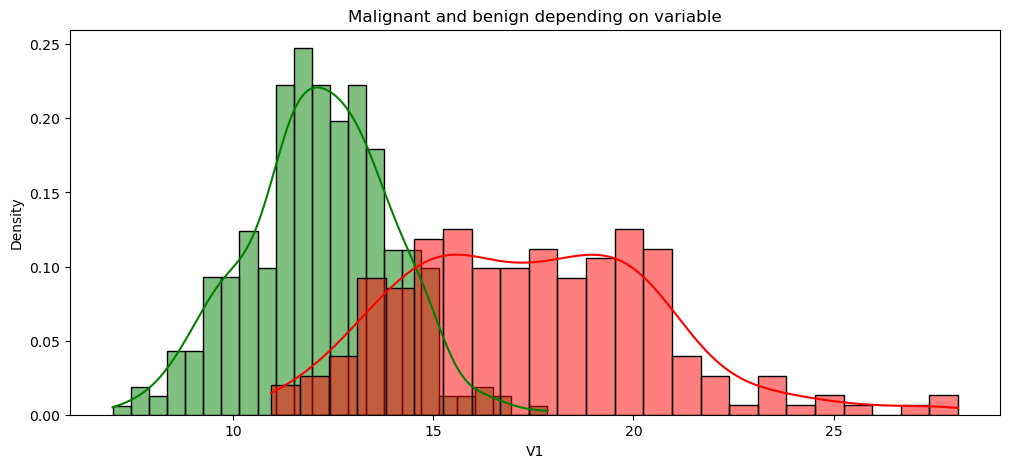

In [5]:
plt.figure(figsize=(12,5))
sns.histplot(df[df['Class'] == 0]["V1"], color='g', bins=24, kde=True, stat="density")
sns.histplot(df[df['Class'] == 1]["V1"], color='r', bins=24, kde=True, stat="density")
plt.title('Malignant and benign depending on variable')

### Feature Engineering
- Scale and Transform for all variables
- Use standard scaler and PCA

### Visualisation of Features Distribution

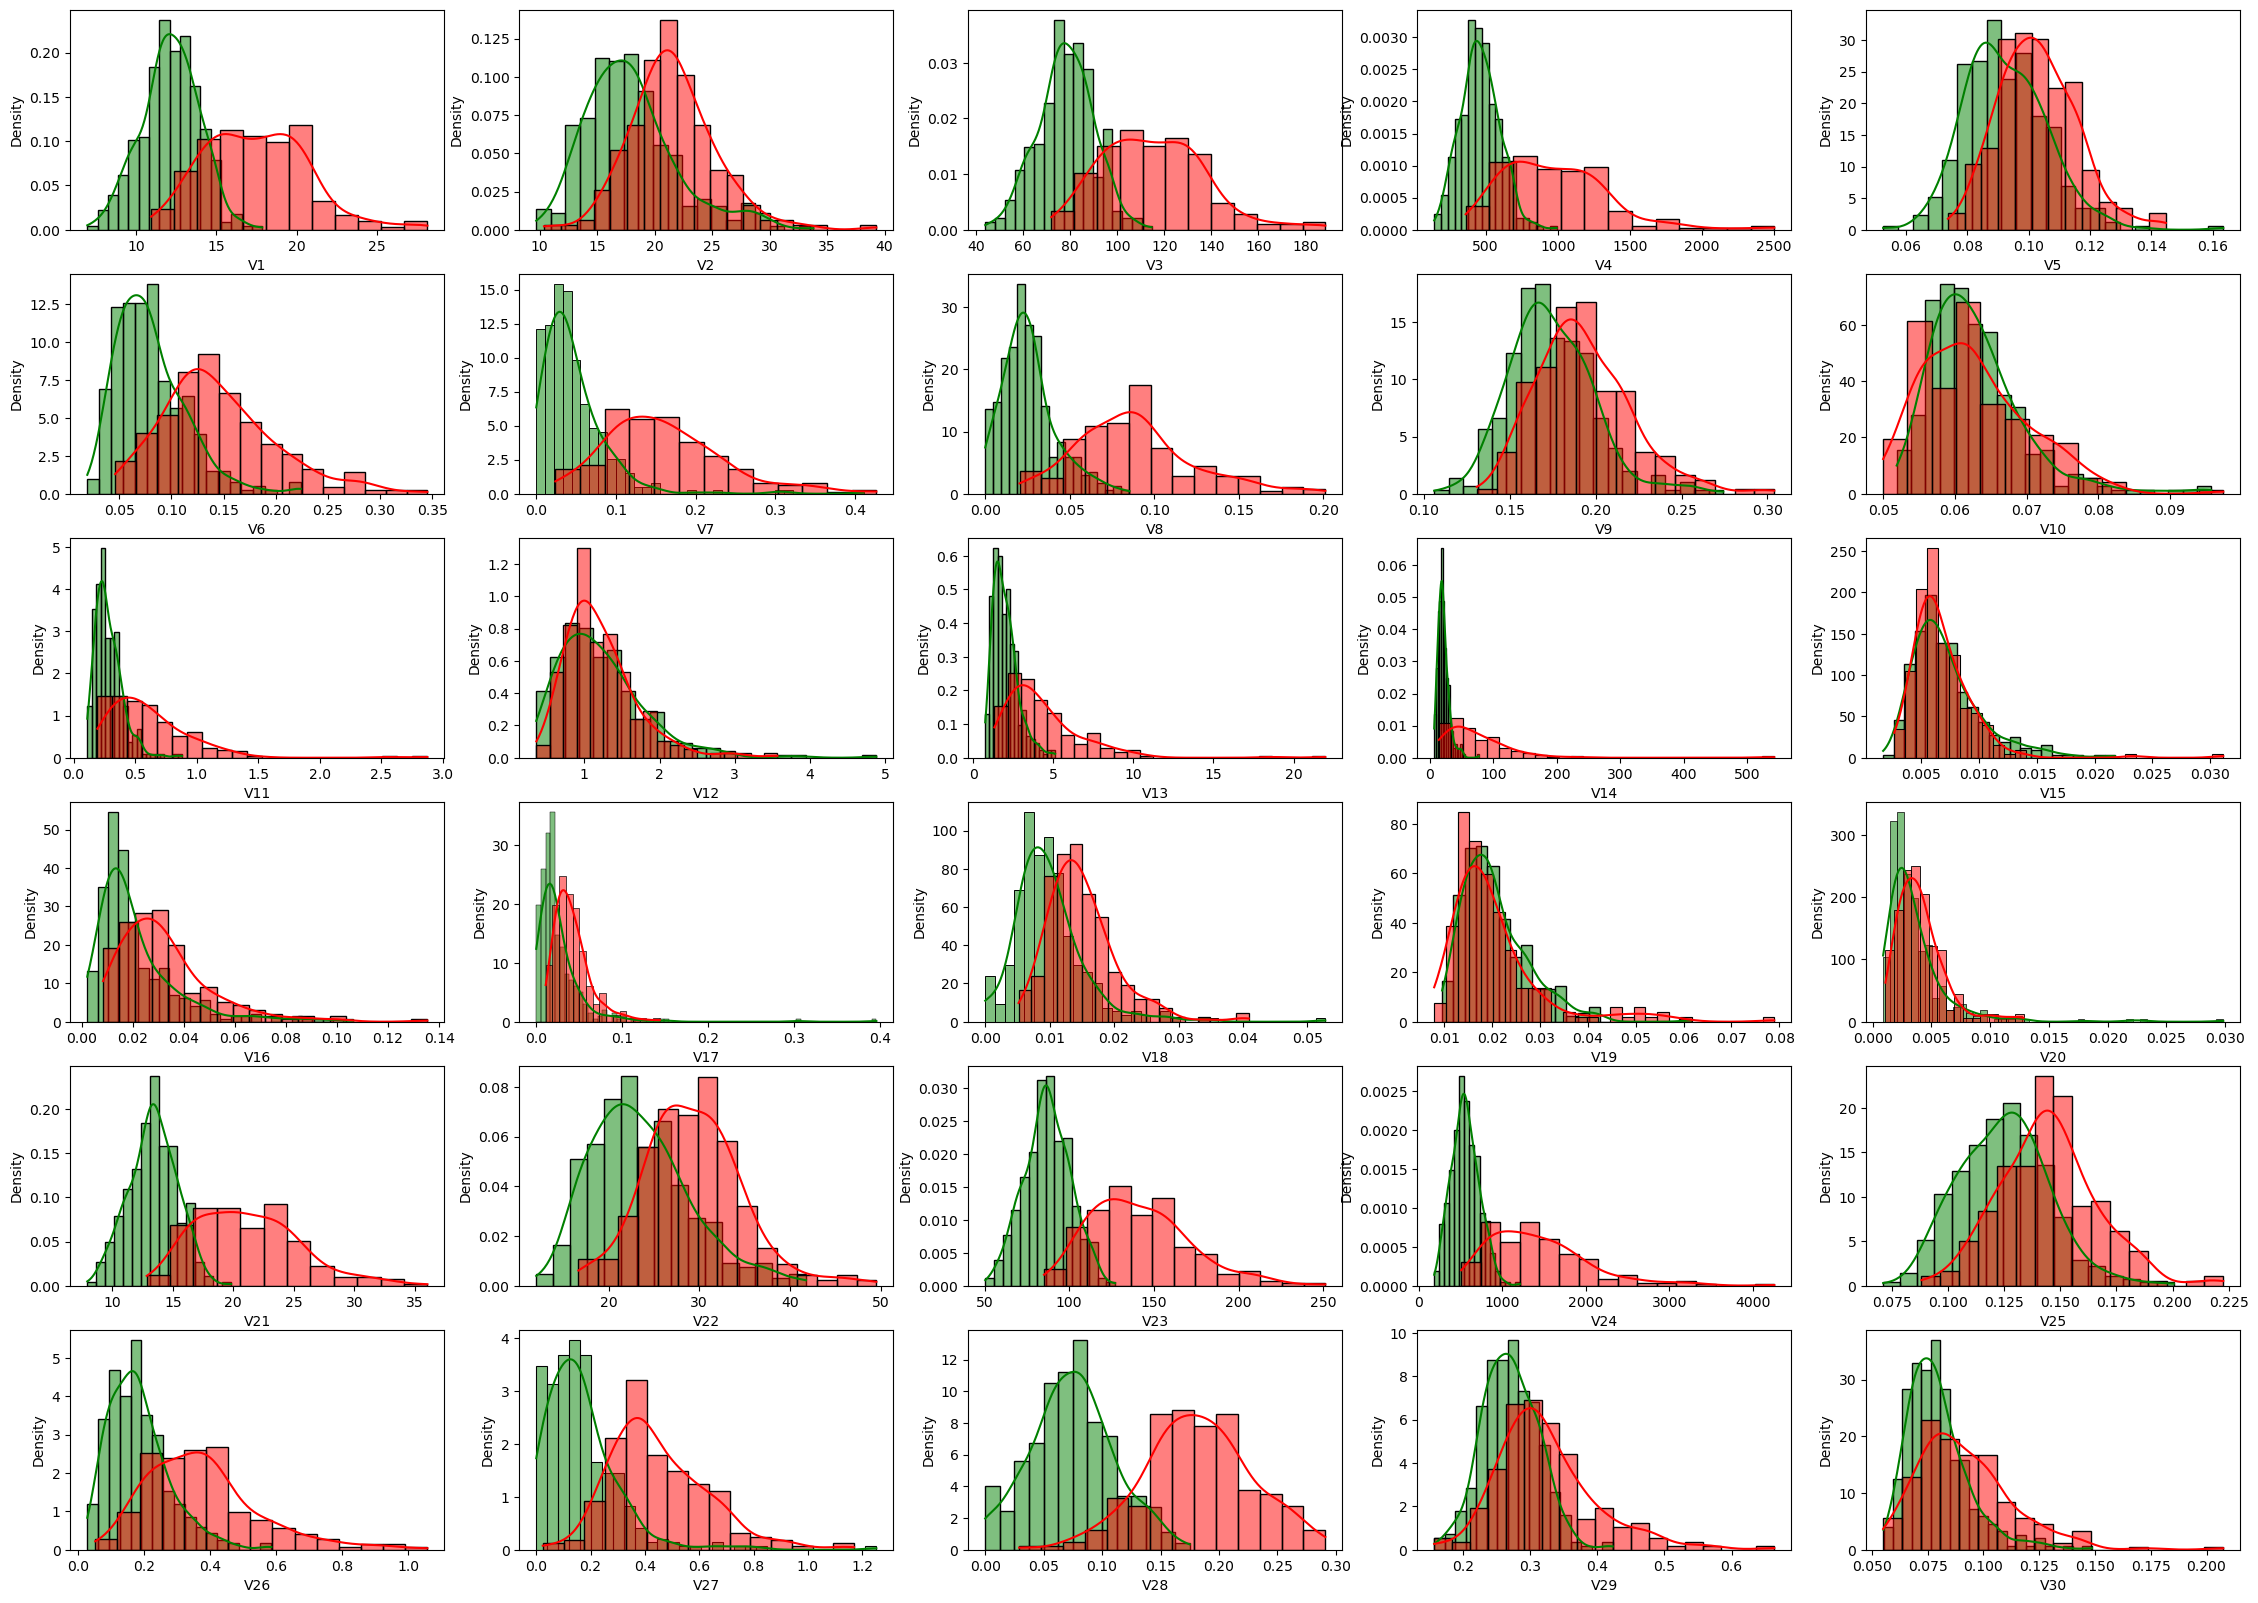

In [6]:
grid = gridspec.GridSpec(6, 5)
plt.figure(figsize=(28, 20))

for i in range(30):
    ax = plt.subplot(grid[i])
    sns.histplot(df[df['Class'] == 0][f"V{i+1}"], color='g', kde=True, stat="density")
    sns.histplot(df[df['Class'] == 1][f"V{i+1}"], color='r', kde=True, stat="density")

plt.show()

### Explained Variance Ratio
- need to scale features
- over 90 % of variance ratio is explained by only 7 dimensions

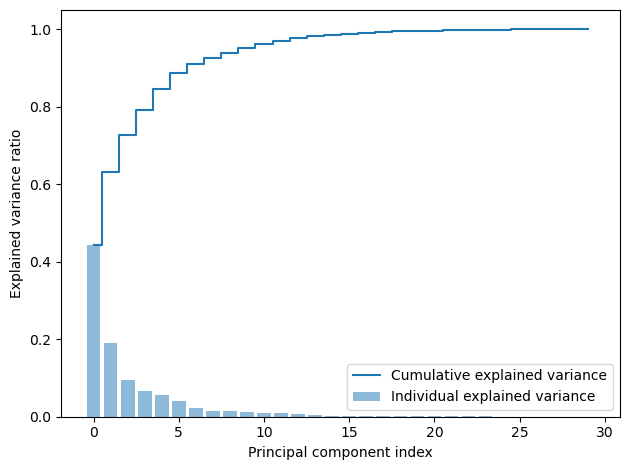

In [7]:
# models
sc = StandardScaler()
pca = PCA()

# prepare data to transform
X_train = df[cols_variables]

# transform SC and PCA
X_train_sc = sc.fit_transform(X_train)
df[cols_variables_t] = X_train_sc 
X_train_pca = pca.fit_transform(X_train_sc)

# compute explained variance ratio
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# create the visualization plot
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Compute PCA
- use only 7 dimensions

In [8]:
cols_variables_pca = [f'PCA{i+1}' for i in range(7)]

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_sc)
df[cols_variables_pca] = X_train_pca
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,T28,T29,T30,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,2.296076,2.750622,1.937015,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159375
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,1.087084,-0.243890,0.281190,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013348
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,1.955000,1.152255,0.201391,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668176
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,2.175786,6.046041,4.935010,7.122953,10.275589,-3.232790,0.152547,-2.960879,3.053421,1.429906
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,0.729259,-0.868353,-0.397100,3.935302,-1.948072,1.389767,2.940639,0.546748,-1.226494,-0.936200


### Visualisation of Features Dependencies
- showing dependencies between first five variables

Number of pairs is: 10


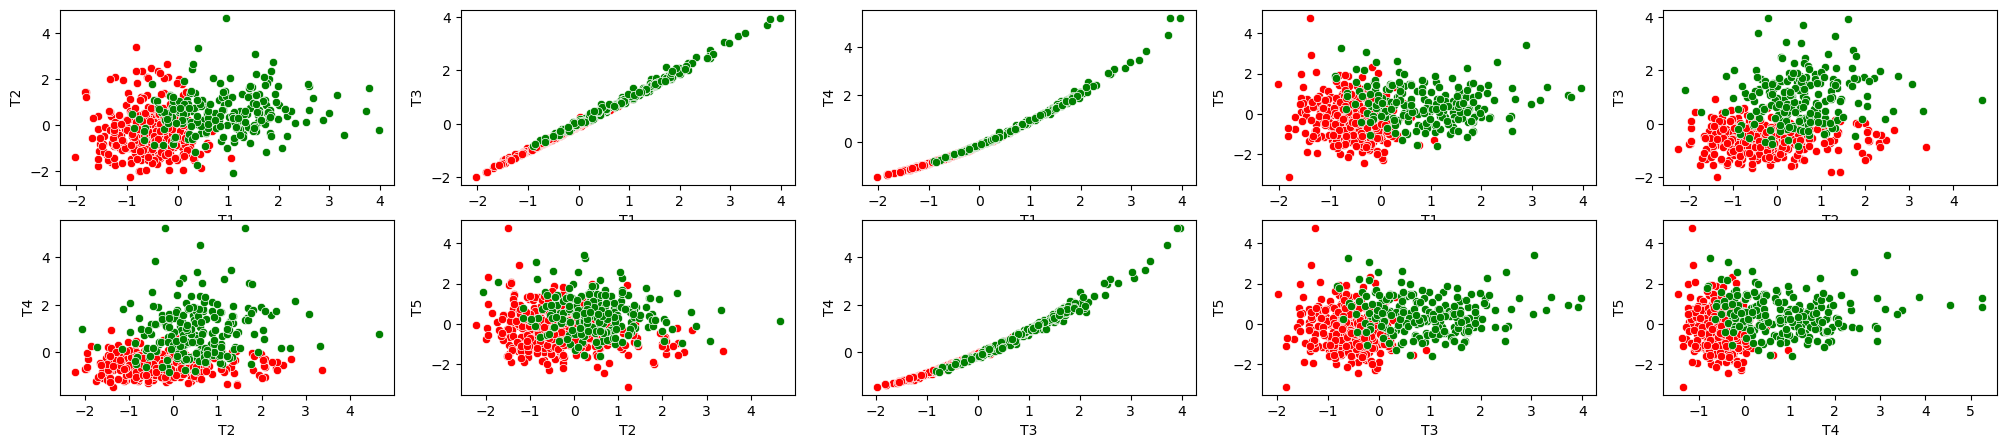

In [9]:
LIMIT_SHOW = 5
cols_variables_sample = cols_variables_t[:LIMIT_SHOW]

num_images = LIMIT_SHOW * (LIMIT_SHOW - 1) // 2
print(f'Number of pairs is: {num_images}')
grid = gridspec.GridSpec(2, 5)
plt.figure(figsize=(25, 5))

grid_index = 0
for i in range(LIMIT_SHOW):
    for j in range(i+1, LIMIT_SHOW):
        col1 = cols_variables_sample[i]
        col2 = cols_variables_sample[j]
        ax = plt.subplot(grid[grid_index])
        sns.scatterplot(data=df[df["Class"]== 0], x=col1, y=col2, color='r')
        sns.scatterplot(data=df[df["Class"]== 1], x=col1, y=col2, color='g')
        grid_index += 1

plt.show()

### Visualisation of Features Dependencies
- showing dependencies between seven PCA transformed variables

Number of pairs is: 21


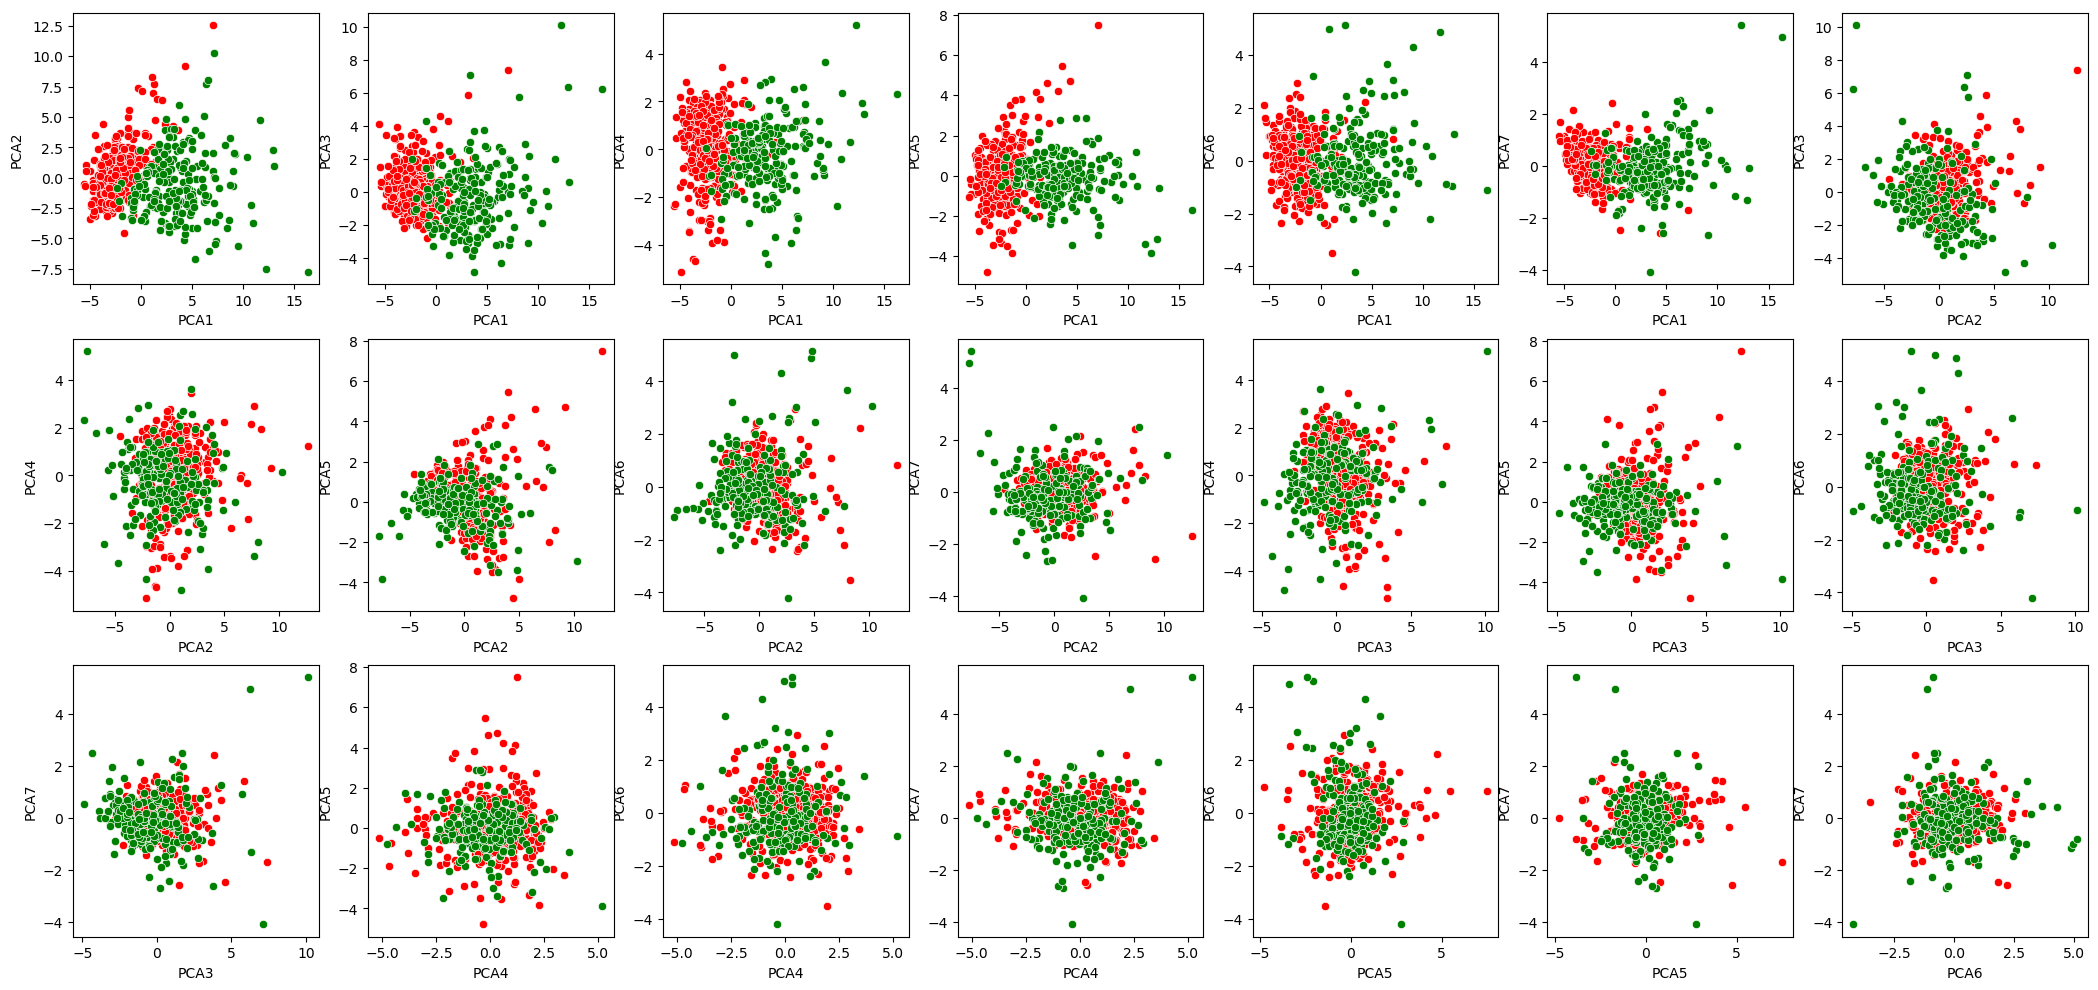

In [10]:
LIMIT_SHOW = 7
cols_variables_sample = cols_variables_pca[:LIMIT_SHOW]

num_images = LIMIT_SHOW * (LIMIT_SHOW - 1) // 2
print(f'Number of pairs is: {num_images}')
grid = gridspec.GridSpec(3, 7)
plt.figure(figsize=(26, 12))

grid_index = 0
for i in range(LIMIT_SHOW):
    for j in range(i+1, LIMIT_SHOW):
        col1 = cols_variables_sample[i]
        col2 = cols_variables_sample[j]
        ax = plt.subplot(grid[grid_index])
        sns.scatterplot(data=df[df["Class"]== 0], x=col1, y=col2, color='r')
        sns.scatterplot(data=df[df["Class"]== 1], x=col1, y=col2, color='g')
        grid_index += 1

plt.show()

### PCA of all features for visualisation
- PCA for visualisation with two dimensions

<Axes: xlabel='pca_1', ylabel='pca_2'>

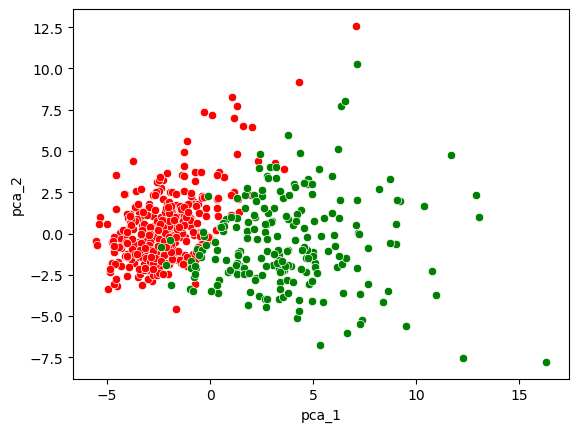

In [11]:
targets = df["Class"].to_numpy().reshape(-1, 1)
pca_n2 = PCA(n_components=2)
X_train_pca_n2 = pca_n2.fit_transform(X_train_sc)
result_np = np.concatenate((X_train_pca_n2, targets), axis=1)
result_df = pd.DataFrame(result_np, columns=['pca_1', 'pca_2', 'target'])

sns.scatterplot(data=result_df[result_df["target"]== 0], x="pca_1", y="pca_2", color='r')
sns.scatterplot(data=result_df[result_df["target"]== 1], x="pca_1", y="pca_2", color='g')

### tSNE of all features

/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.000s...
[t-SNE] Computed neighbors for 569 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.414330
[t-SNE] Computed conditional probabilities in 0.013s
[t-SNE] Iteration 50: error = 61.3947868, gradient norm = 0.3163928 (50 iterations in 0.200s)
[t-SNE] Iteration 100: error = 60.4489632, gradient norm = 0.2898346 (50 iterations in 0.093s)


[t-SNE] Iteration 150: error = 60.5646400, gradient norm = 0.2644418 (50 iterations in 0.126s)
[t-SNE] Iteration 200: error = 60.4656639, gradient norm = 0.2825578 (50 iterations in 0.105s)
[t-SNE] Iteration 250: error = 60.3199081, gradient norm = 0.2966450 (50 iterations in 0.109s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.319908
[t-SNE] Iteration 300: error = 1.0952842, gradient norm = 0.0017873 (50 iterations in 0.102s)
[t-SNE] Iteration 350: error = 1.0209082, gradient norm = 0.0004521 (50 iterations in 0.101s)
[t-SNE] Iteration 400: error = 1.0084462, gradient norm = 0.0001308 (50 iterations in 0.095s)
[t-SNE] Iteration 450: error = 1.0044653, gradient norm = 0.0000718 (50 iterations in 0.101s)
[t-SNE] Iteration 500: error = 1.0029757, gradient norm = 0.0000482 (50 iterations in 0.100s)
[t-SNE] Iteration 550: error = 1.0023228, gradient norm = 0.0000304 (50 iterations in 0.142s)
[t-SNE] Iteration 600: error = 1.0018922, gradient norm = 0.0000341 (50 i

<Axes: xlabel='tsne_1', ylabel='tsne_2'>

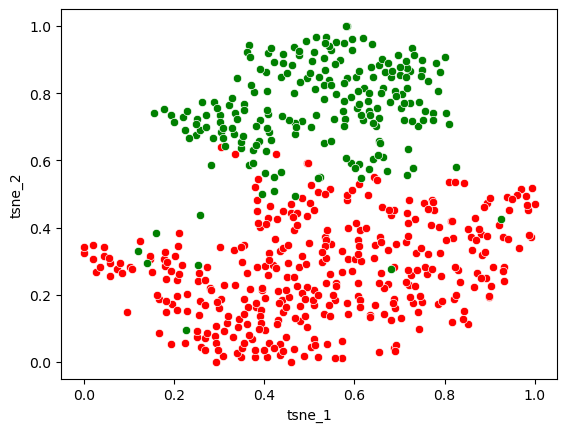

In [12]:
tsne = TSNE(n_components=2, learning_rate=100, perplexity=30, angle=0.2, verbose=2, n_iter=1200, n_iter_without_progress=50, random_state=42).fit_transform(X_train_sc)
tx, ty = tsne[:, 0], tsne[:, 1]
tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

result_np = np.concatenate((tx.reshape(-1, 1), ty.reshape(-1, 1), targets), axis=1)
result_df = pd.DataFrame(result_np, columns=['tsne_1', 'tsne_2', 'target'])

sns.scatterplot(data=result_df[result_df["target"]== 0], x="tsne_1", y="tsne_2", color='r')
sns.scatterplot(data=result_df[result_df["target"]== 1], x="tsne_1", y="tsne_2", color='g')

## 2. Features Selection
- in a case we know targets (if not, we use all variables)
- Z-test - hypothesis testing
- figure out if the values of fraud transactions are significantly different from normal transaction or not for all features
- H0: There is no difference (insignificant)
- H1: There is a difference (significant)

In [13]:
def ztest(column):
    
    mean = normal[column].mean()
    std = fraud[column].std()
    z_score = (fraud[column].mean() - mean) / (std / np.sqrt(len(fraud)))
    
    return z_score

normal = df[df["Class"] == 0]
fraud = df[df["Class"] == 1]
significant_features = []
critical_value = 2.58

for col in cols_variables:
    
    z = ztest(col)
    
    # Reject Null hypothesis. i.e. H0
    if (abs(z) >= critical_value):  

        significant_features.append(col)
    else:
        
        print(col, " is NOT statistically significant", abs(z))

df_significant = df[significant_features + ["Class"]]
df_significant.head()

V10  is NOT statistically significant 0.3600983399022206
V12  is NOT statistically significant 0.28523563582228484
V15  is NOT statistically significant 2.0945847138579547
V19  is NOT statistically significant 0.1611634982490113


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V11,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## 3. Modeling

### Functions

In [14]:
def evaluate_metrics(prediction_column, print_metrics=True):

    precision, recall, thresholds = precision_recall_curve(df_significant["Class"], df_significant[prediction_column])
    auc_precision_recall = auc(recall, precision)
    f1 = f1_score(df_significant["Class"], df_significant[prediction_column])
    if print_metrics:
        print(f'AUC-PR:    {auc_precision_recall}')
        print(f'F1 score:  {f1}')

    return precision, recall, auc_precision_recall, f1


def show_precision_recall_curve(precision, recall):

    plt.plot(recall, precision)
    plt.title('Precision recall curve')
    plt.show()


def show_confusion_matrix(prediction_column):
    
    cm = confusion_matrix(df_significant["Class"], df_significant[prediction_column])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix')
    plt.show()


def evaluate_results(prediction_column):

    precision, recall, auc_precision_recall, f1 = evaluate_metrics(prediction_column)
    show_precision_recall_curve(precision, recall)
    show_confusion_matrix(prediction_column)


def evaluate_metrics_all(prediction_columns):

    final_results = np.zeros(shape=(2, len(prediction_columns)))

    for i, prediction_column in enumerate(prediction_columns):

        precision, recall, auc_precision_recall, f1 = evaluate_metrics(prediction_column, print_metrics=False)
        final_results[0, i] = auc_precision_recall
        final_results[1, i] = f1

    return final_results


def show_results_all(prediction_columns):

    fig, axs = plt.subplots(2, len(prediction_columns), figsize=(25, 10))

    for i, prediction_column in enumerate(prediction_columns):

        precision, recall, auc_precision_recall, f1 = evaluate_metrics(prediction_column, print_metrics=False)

        # Precision recall curve
        axs[0, i].plot(recall, precision)
        axs[0, i].set_title(f'AUC-PR {prediction_column}')

        # Confusion matrix
        cm = confusion_matrix(df_significant["Class"], df_significant[prediction_column])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axs[1, i])
        axs[1, i].set_title(f'Confusion matrix {prediction_column}')

    plt.show()

### Split train, test, valid

In [15]:
df_significant = df[significant_features + ["Class"]]
X_train = df_significant[significant_features]
y_train = df_significant["Class"]

X_inliers = df_significant[df_significant["Class"] == 0].drop(["Class"], axis=1)
X_outliers = df_significant[df_significant["Class"] == 1].drop(["Class"], axis=1)

inliers_size = X_inliers.shape[0]
outliers_size = X_outliers.shape[0]

X_inliers_train = X_inliers[:inliers_size*60//100]
X_inliers_valid = X_inliers[(inliers_size*60//100)+1:(inliers_size*80//100)]
X_inliers_test = X_inliers[(inliers_size*80//100)+1:]

X_outliers_valid = X_outliers[:outliers_size*50//100]
X_outliers_test = X_outliers[(outliers_size*50//100)+1:]

X_valid = pd.concat([X_inliers_valid, X_outliers_valid])
X_test = pd.concat([X_inliers_test, X_outliers_test])

y_valid = (len(X_inliers_valid) * [0]) + (len(X_outliers_valid) * [1])
y_test = (len(X_inliers_test) * [0]) + (len(X_outliers_test) * [1])


print(f"Number of significant features: {df_significant.shape[1] - 1}")
print(f"Inliers: {inliers_size} Outliers: {outliers_size}")

Number of significant features: 26
Inliers: 357 Outliers: 212


### Gaussian Mixture

In [18]:
def gmm_bic_score(estimator, X):
    """
    Callable to pass to GridSearchCV that will use the BIC score.
    """
    # Make it negative since GridSearchCV expects a score to maximize
    return - estimator.bic(X)


param_grid = {
    "n_components": range(1, 20),
    "covariance_type": ["full", "diag", "spherical", "tied"],
    "max_iter": [200, 500]
}

gm_grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
gm_grid_search.fit(X_train)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'diag', 'spherical',
                                             'tied'],
                         'max_iter': [200, 500], 'n_components': range(1, 20)},
             scoring=<function gmm_bic_score at 0x7fbe563de940>)

### Show BIC based on parameters
- Bayesian information criterion

In [24]:
df_gm = pd.DataFrame(gm_grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score", "param_max_iter"]
]
df_gm["mean_test_score"] = -df_gm["mean_test_score"]
df_gm = df_gm.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "param_max_iter": "Maximum number of iterations",
        "mean_test_score": "BIC score",
    }
)
df_gm.sort_values(by="BIC score").head(n=50)

,Number of components,Type of covariance,BIC score,Maximum number of iterations
0,1,full,-1713.772192,200
19,1,full,-1713.772192,500
114,1,tied,-1713.772192,200
133,1,tied,-1713.772192,500
115,2,tied,-1616.796004,200
134,2,tied,-1614.093955,500
135,3,tied,-1530.334890,500
116,3,tied,-1503.446262,200
136,4,tied,-1411.272638,500
117,4,tied,-1409.474756,200


### Visualisation of clusters

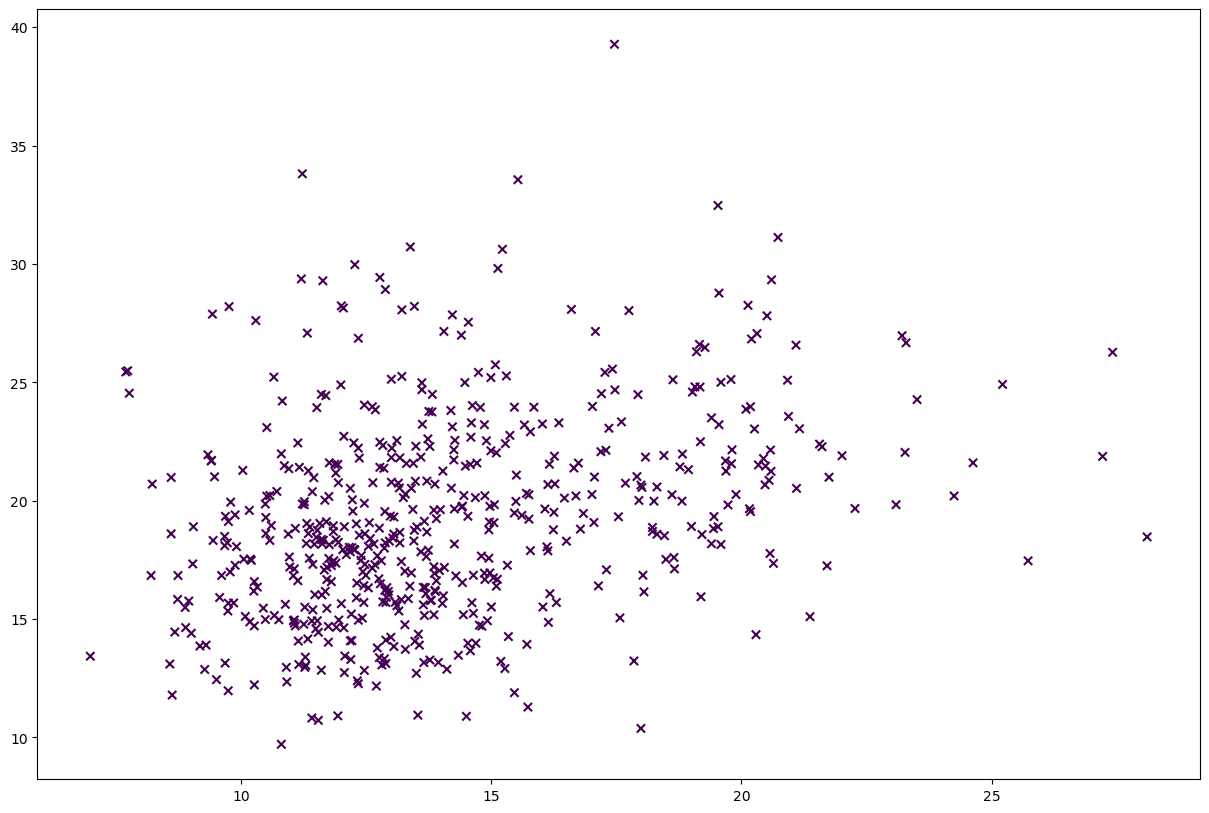

In [32]:
plt.figure(figsize=(15, 10))

for i in range(1):
    
    plt.scatter(X_train.to_numpy()[:, 0], X_train.to_numpy()[:, 1], c=gm_grid_search.predict_proba(X_train)[:,i], cmap='viridis',marker='x')

### Compute predictions from cluster probabilities

In [37]:
clusters_predictions = pd.DataFrame(gm_grid_search.predict_proba(X_train))

In [ ]:
#proba_complement = 1
#for i in range(2):
#    proba_complement = proba_complement * (1 - clusters_predictions[i])

#clusters_predictions["proba"] = 1 - proba_complement
#clusters_predictions

### Multivariate Gaussian Probability Distribution
- compute PDF = probability density function

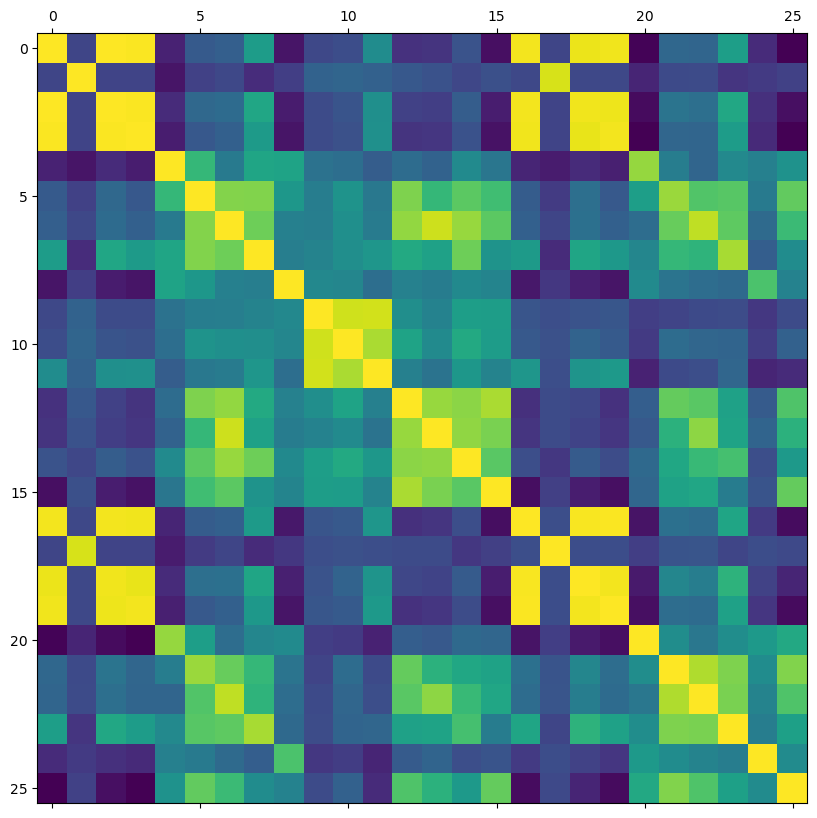

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(X_inliers.corr())
plt.show()

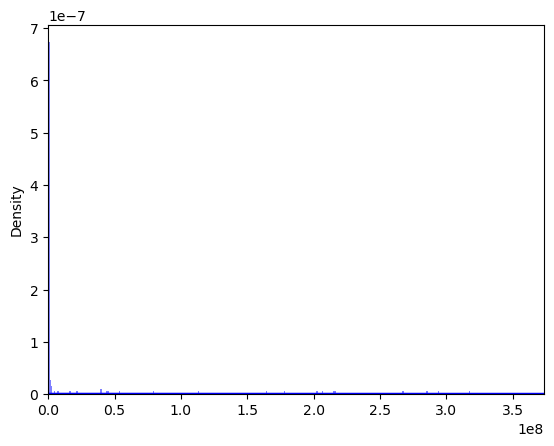

In [85]:
prediction_column = 'Pred_MG_PDF'
EPSILON = 1e-18

p = multivariate_normal(mean=np.mean(X_inliers_train, axis=0), cov=np.cov(X_inliers_train.T), allow_singular=True)
prob_density = p.pdf(X_valid)
sns.histplot(prob_density, color='b', kde=True, stat="density")
plt.xlim(0, prob_density.mean())

pred_valid = (prob_density < EPSILON).astype(int)

#### Evaluation on validation set

AUC-PR:    0.9437178387650086
F1 score:  0.8351648351648352


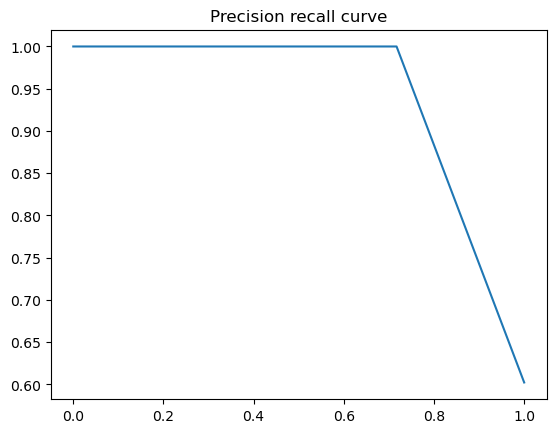

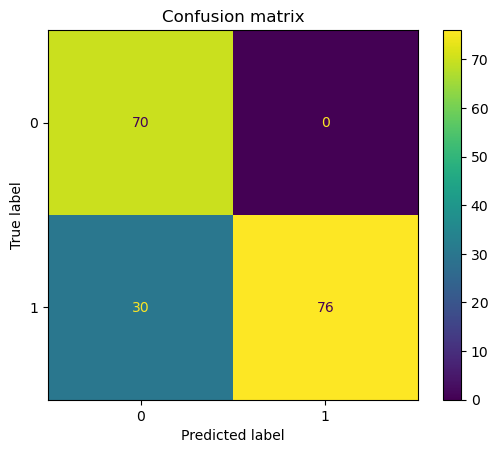

In [86]:
precision, recall, thresholds = precision_recall_curve(y_valid, pred_valid)
auc_precision_recall = auc(recall, precision)
f1 = f1_score(y_valid, pred_valid)
print(f'AUC-PR:    {auc_precision_recall}')
print(f'F1 score:  {f1}')

plt.plot(recall, precision)
plt.title('Precision recall curve')
plt.show()

cm = confusion_matrix(y_valid, pred_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()

#### Evaluation on whole dataset

AUC-PR:    0.9124487829929353
F1 score:  0.842391304347826


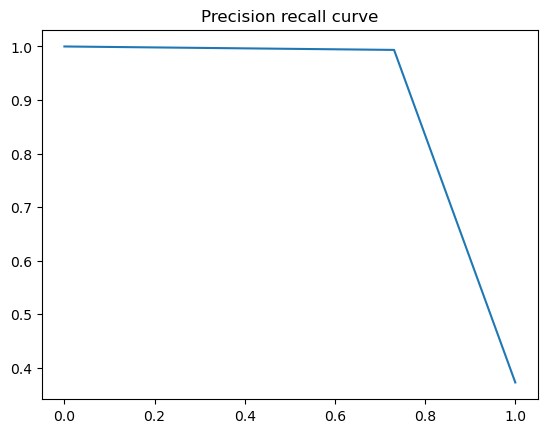

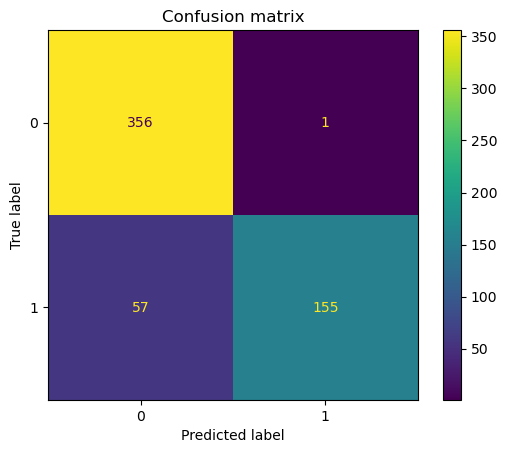

In [87]:
p = multivariate_normal(mean=np.mean(X_inliers_train, axis=0), cov=np.cov(X_inliers_train.T), allow_singular=True)
prob_density = p.pdf(X_train)
df_significant.loc[:, prediction_column] = (prob_density < EPSILON).astype(int)
evaluate_results(prediction_column)

### Isolation Forrest
- fast and accurate
- not need to scale features
- output is -1 for outliers and 1 for inliers -> transform to 1 and 0 by (x + 2) % 3
- pros is knowing contamination size
- evaluation: if contamination size not specified then generates many FP -> not reliable but for detecting fraud transactions it is not a big issue, if we specify contamination size then FP and TN almost the same and only 1/4 of FN revealed

In [100]:
prediction_column = 'Pred_ISF'
N_ESTIMATORS = [i for i in range(1, 50)]
AUC_PR = np.zeros(shape=(len(N_ESTIMATORS,)))
F1_SCORES = np.zeros(shape=(len(N_ESTIMATORS,)))

for i, n_estimators in enumerate(N_ESTIMATORS):
    
    ISF = IsolationForest(n_estimators=n_estimators, max_features=1.0, max_samples=1.0, bootstrap=False, random_state=42, contamination=CONTAMINATION)
    prediction_raw = ISF.fit_predict(X_train)
    prediction = (prediction_raw + 2) % 3

    precision, recall, thresholds = precision_recall_curve(df_significant["Class"], prediction)
    auc_precision_recall = auc(recall, precision)
    f1 = f1_score(df_significant["Class"], prediction)

    AUC_PR[i] = auc_precision_recall
    F1_SCORES[i] = f1

/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/ba

/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/ba

Text(0, 0.5, 'Value of metric')

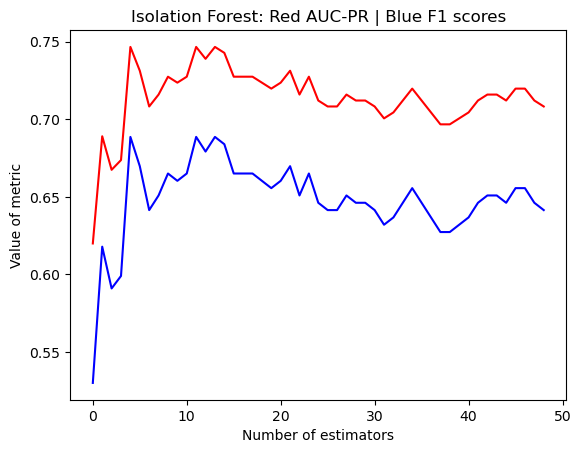

In [122]:
plt.plot(np.arange(len(N_ESTIMATORS)), AUC_PR, c='red')
plt.plot(np.arange(len(N_ESTIMATORS)), F1_SCORES, c='blue')
plt.title('Isolation Forest: Red AUC-PR | Blue F1 scores')
plt.xlabel('Number of estimators')
plt.ylabel('Value of metric')

AUC-PR:    0.7466757303445303
F1 score:  0.6886792452830188


/anaconda/envs/an_env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


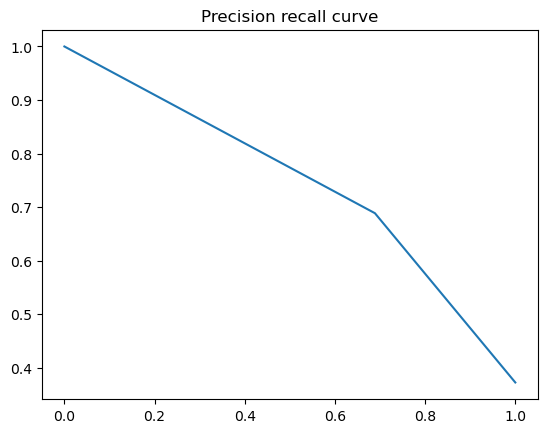

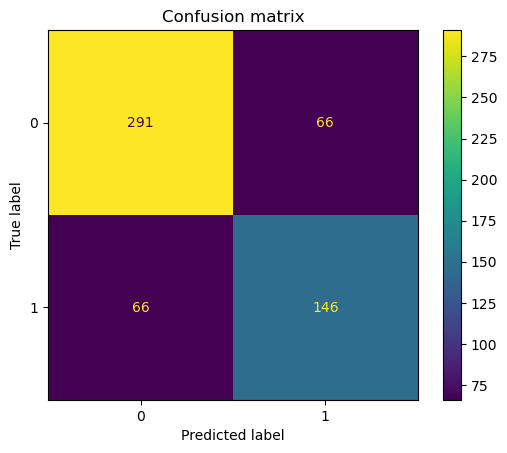

In [125]:
ISF = IsolationForest(n_estimators=np.argmax(AUC_PR)+1, max_features=1.0, max_samples=1.0, bootstrap=False, random_state=42, contamination=CONTAMINATION)
prediction_raw = ISF.fit_predict(X_train)
prediction = (prediction_raw + 2) % 3
df_significant.loc[:, prediction_column] = (prediction_raw + 2) % 3
evaluate_results(prediction_column)

### Local Outlier Factor
- very slow computation without PCA transformation
- tried to PCA with 10 components and it was much faster, 
- knowing contamination size did not help to achieve better results
- PCA n_components = 10
    - n_neighbors 21 -> 3 min training
    - n_neighbors = 50 -> 4 min training
    - n_neighbors = 100 -> 5 min 48 s training (190 false negatives)
- PCA  n_components = 13
    - n_neighbors = 100 -> 13 min (69 false negatives)

In [137]:
prediction_column = 'Pred_LOF'

N_NEIGHBORS = [i for i in range(1, 500)]
AUC_PR = np.zeros(shape=(len(N_NEIGHBORS,)))
F1_SCORES = np.zeros(shape=(len(N_NEIGHBORS,)))

for i, n_neighbors in enumerate(N_NEIGHBORS):
    
    LOF = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=CONTAMINATION)
    prediction_raw = LOF.fit_predict(X_train_sc)
    prediction = (prediction_raw + 2) % 3

    precision, recall, thresholds = precision_recall_curve(df_significant["Class"], prediction)
    auc_precision_recall = auc(recall, precision)
    f1 = f1_score(df_significant["Class"], prediction)

    AUC_PR[i] = auc_precision_recall
    F1_SCORES[i] = f1

Text(0, 0.5, 'Value of metric')

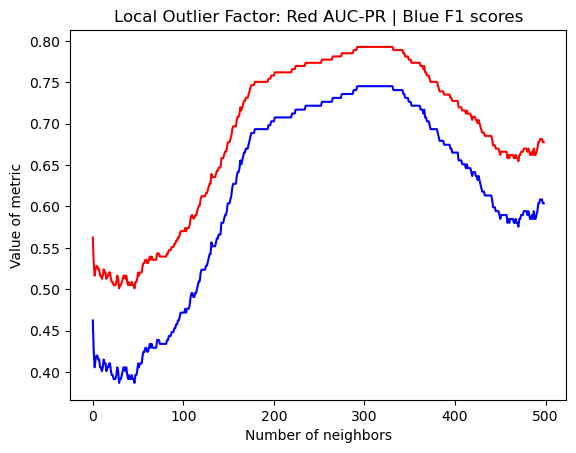

In [138]:
plt.plot(np.arange(len(N_NEIGHBORS)), AUC_PR, c='red')
plt.plot(np.arange(len(N_NEIGHBORS)), F1_SCORES, c='blue')
plt.title('Local Outlier Factor: Red AUC-PR | Blue F1 scores')
plt.xlabel('Number of neighbors')
plt.ylabel('Value of metric')

AUC-PR:    0.8426318930928143
F1 score:  0.8066037735849056


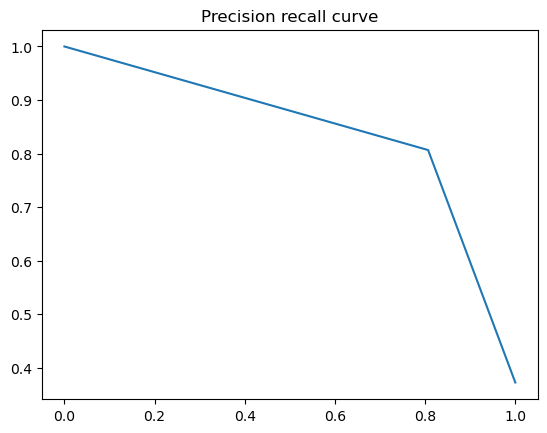

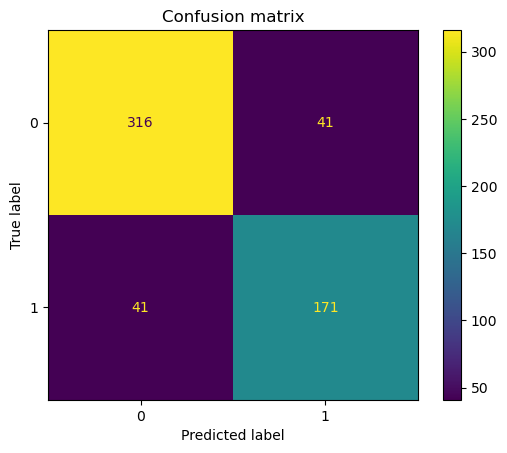

In [144]:
LOF = LocalOutlierFactor(n_neighbors=np.argmax(AUC_PR)+1, contamination=CONTAMINATION)
prediction_raw = LOF.fit_predict(X_train)
prediction = (prediction_raw + 2) % 3
df_significant.loc[:, prediction_column] = (prediction_raw + 2) % 3
evaluate_results(prediction_column)

### Robust Covariance (Elliptic Envelope)

In [169]:
prediction_column = 'Pred_ELE'
SUPPORT_FRACTION=0.48

ELE = EllipticEnvelope(support_fraction=SUPPORT_FRACTION, contamination=CONTAMINATION)
prediction_raw = ELE.fit_predict(X_train)
df_significant.loc[:, prediction_column] = (prediction_raw + 2) % 3

AUC-PR:    0.8464701396027456
F1 score:  0.8113207547169812


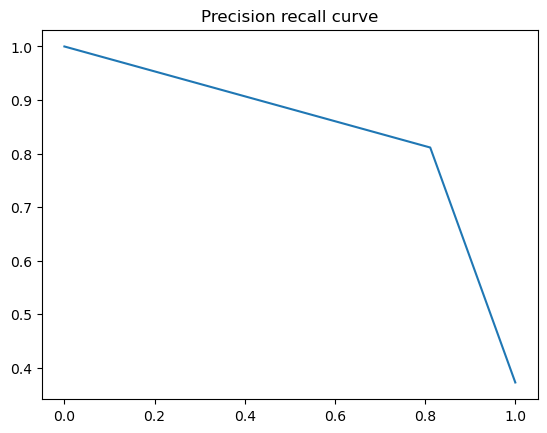

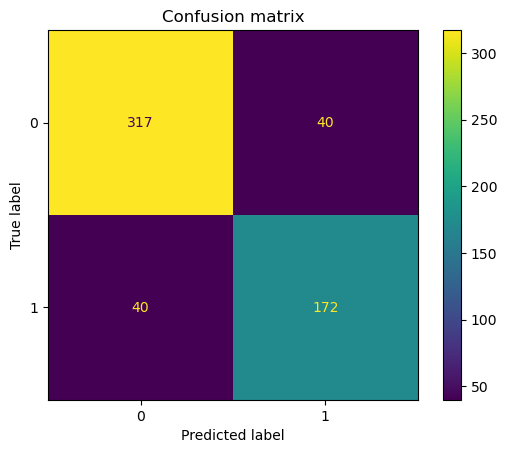

In [170]:
evaluate_results(prediction_column)

## 4.  Evaluation & Model Comparison 

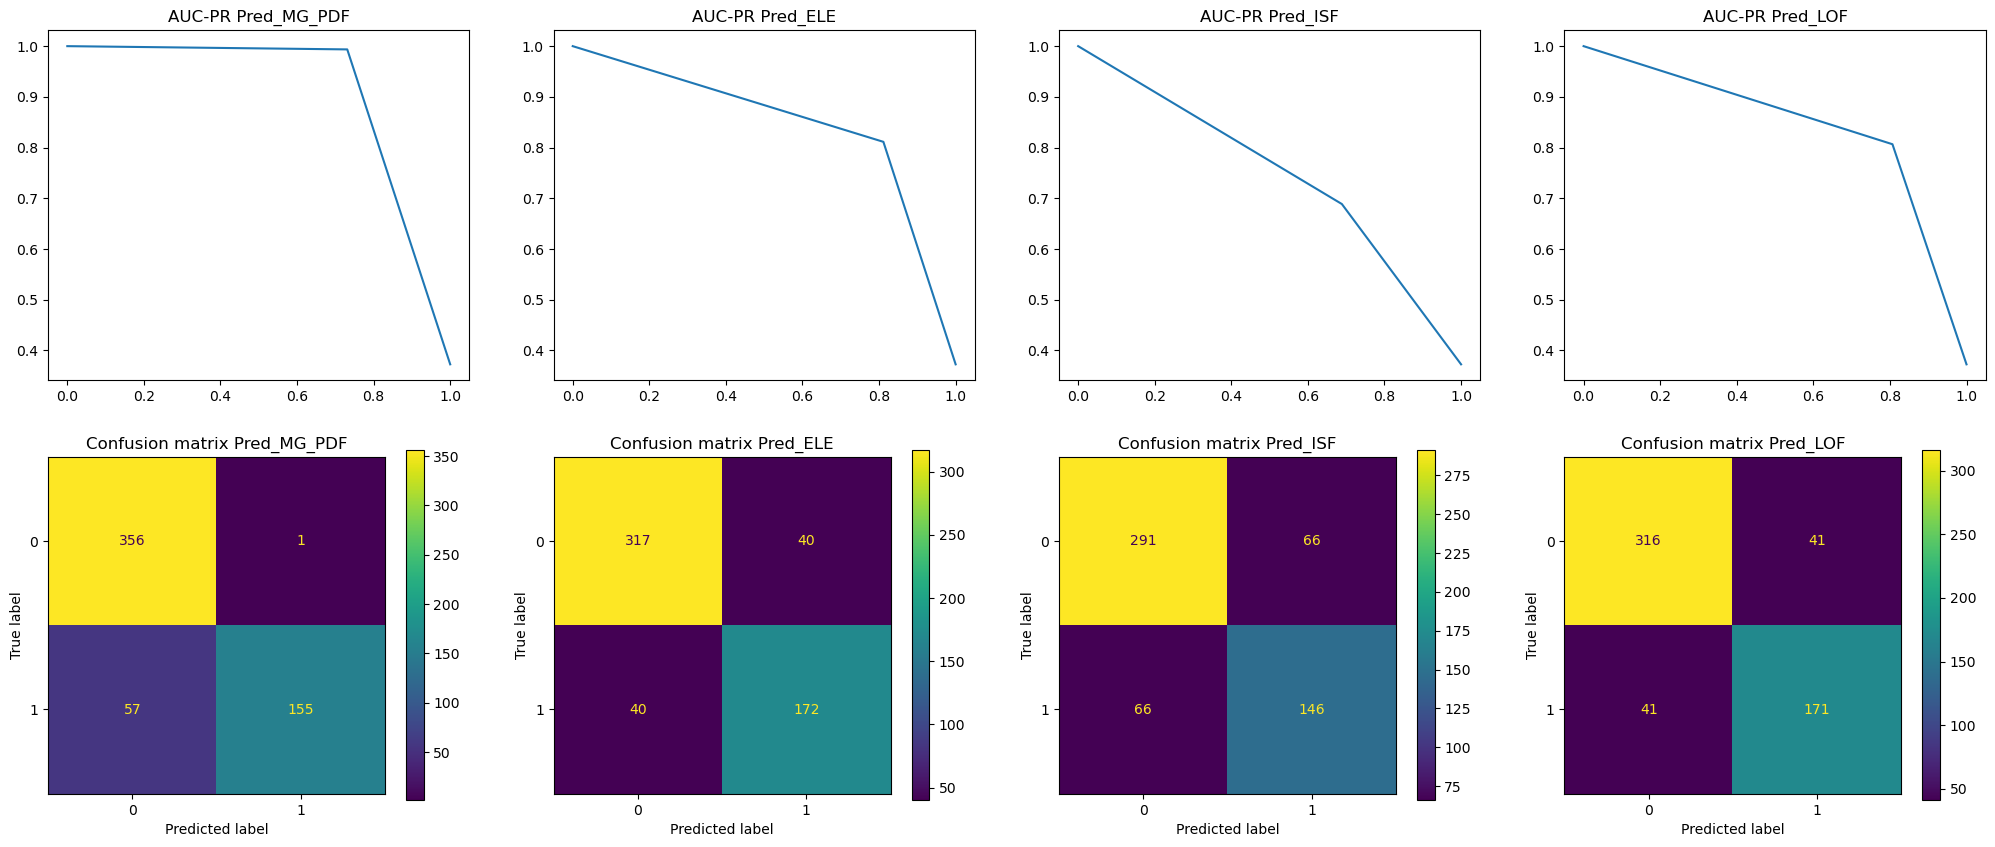

In [171]:
prediction_columns = ['Pred_MG_PDF', 'Pred_ELE', 'Pred_ISF', 'Pred_LOF']
show_results_all(prediction_columns)

Text(0.5, 1.0, 'Metrics results')

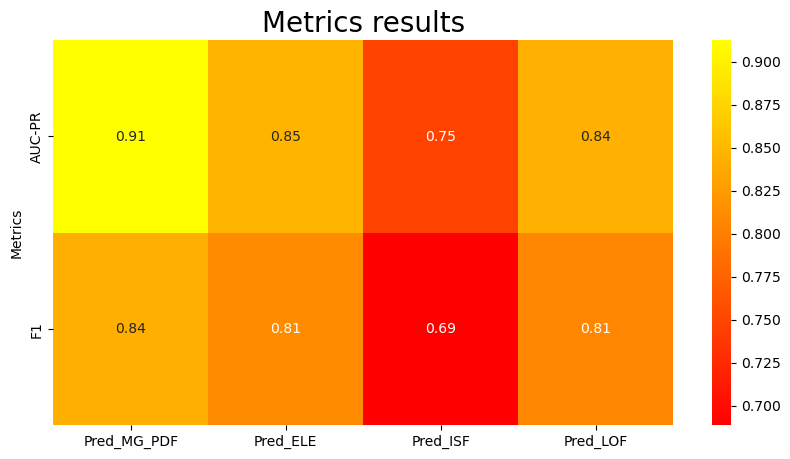

Bad pipe message: %s [b'Q\xda^\xcc\x04J\xf3 \x97z\x85\xd62\xb59\r\x9a\xa0\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf']
Bad pipe message: %s [b"\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08", b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b"\x9b/\x02&\x89r\xa6\xb0\xbc\xd6;4\xba\x0f u\x03\x01\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a

In [172]:
final_metrics_table = pd.DataFrame(evaluate_metrics_all(prediction_columns), columns=prediction_columns)
final_metrics_table["Metrics"] = ["AUC-PR", "F1"]
final_metrics_table.set_index("Metrics", inplace=True)
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(final_metrics_table, annot=True, cmap='autumn')
plt.title("Metrics results", fontsize=20)